<a href="https://colab.research.google.com/github/tackulus/229352_BOOTCAMP/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!git clone https://github.com/tackulus/229352_BOOTCAMP.git

Cloning into '229352_BOOTCAMP'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [3]:
import glob

paths = glob.glob("/content/229352_BOOTCAMP/PREPROCESSED/" + "*.csv")
paths.sort()
paths

['/content/229352_BOOTCAMP/PREPROCESSED/01_max_temperature.csv',
 '/content/229352_BOOTCAMP/PREPROCESSED/02_min_temperature.csv',
 '/content/229352_BOOTCAMP/PREPROCESSED/03_dry_temperature.csv',
 '/content/229352_BOOTCAMP/PREPROCESSED/04_reletive_humidity.csv',
 '/content/229352_BOOTCAMP/PREPROCESSED/05_max_wind_direction.csv',
 '/content/229352_BOOTCAMP/PREPROCESSED/06_max_wind_speed.csv',
 '/content/229352_BOOTCAMP/PREPROCESSED/07_water_eveporation_tray.csv',
 '/content/229352_BOOTCAMP/PREPROCESSED/08_precipitation.csv']

In [4]:
raw_data = list()
for path in paths:
    df = pd.read_csv(path, index_col=0)
    raw_data.append(df)

date_features = raw_data[0].columns.to_list()[:3]
main_features = raw_data[0].columns.to_list()[3:]

prefixed = [df[main_features].add_prefix(f'0{i+1}') for i,df in enumerate(raw_data)]
data = pd.concat([raw_data[0][date_features], *prefixed], axis=1)
data.head()

,year,month,day,01BhumibolDam,01ChiangMai,01ChiangRai,01ChiangRaiAgromet,01DoiMuserAgromet,01KamphaengPhet,01Lampang,01LampangAgromet,01Lamphun,01LomSak,01MaeHongSon,01MaeSariang,01MaeSot,01NakhonSawan,01Nan,01NanAgromet,01Phayao,01Phitsanulok,01Phrae,01PichitAgromet,01SiSamrongAgromet,01Sukhothai,01Tak,01TakFaAgromet,01ThaWangPha,01ThungChang,01Umphang,01Uttaradit,01WichianBuri,02BhumibolDam,02ChiangMai,02ChiangRai,02ChiangRaiAgromet,02DoiMuserAgromet,02KamphaengPhet,02Lampang,02LampangAgromet,...,07Phrae,07PichitAgromet,07SiSamrongAgromet,07Sukhothai,07Tak,07TakFaAgromet,07ThaWangPha,07ThungChang,07Umphang,07Uttaradit,07WichianBuri,08BhumibolDam,08ChiangMai,08ChiangRai,08ChiangRaiAgromet,08DoiMuserAgromet,08KamphaengPhet,08Lampang,08LampangAgromet,08Lamphun,08LomSak,08MaeHongSon,08MaeSariang,08MaeSot,08NakhonSawan,08Nan,08NanAgromet,08Phayao,08Phitsanulok,08Phrae,08PichitAgromet,08SiSamrongAgromet,08Sukhothai,08Tak,08TakFaAgromet,08ThaWangPha,08ThungChang,08Umphang,08Uttaradit,08WichianBuri
0,1993,1,1,30.3,27.8,27.5,26.6,24.7,32.4,30.4,29.5,29.0,33.2,27.3,28.6,30.7,33.2,30.2,29.2,26.5,32.0,30.7,32.4,31.3,33.5,31.0,33.6,29.2,31.8,30.6,31.9,33.5,18.0,14.5,11.5,12.0,12.1,18.9,15.3,14.7,...,2.1,3.5,4.2,4.3,1.7,5.5,2.5,3.4,3.1,3.1,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1993,1,2,30.5,28.7,26.7,27.1,26.2,32.4,30.4,29.6,30.2,33.0,27.2,29.1,30.6,33.0,29.8,29.7,27.3,32.5,30.4,32.2,31.3,33.5,32.0,33.8,29.2,31.8,30.5,31.9,33.8,18.9,15.8,13.1,13.5,12.8,20.0,15.3,15.3,...,1.5,3.8,3.3,4.3,2.1,4.8,2.4,3.4,3.5,2.8,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1993,1,3,31.7,28.6,27.6,27.6,25.0,33.0,31.3,31.0,29.9,33.0,28.2,30.1,30.2,33.5,30.2,29.8,29.7,32.1,31.0,31.9,31.5,33.5,31.5,33.9,29.5,31.8,30.2,32.0,34.0,18.9,13.7,14.4,11.9,11.8,18.9,16.5,15.5,...,2.9,4.0,4.2,4.3,4.2,4.6,2.1,3.4,3.9,3.6,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1993,1,4,31.3,29.1,28.0,27.6,25.4,32.8,30.6,30.2,29.5,32.6,27.5,28.9,30.1,33.9,30.5,29.2,28.9,32.2,31.0,32.1,31.3,33.5,31.6,33.5,29.6,31.8,30.2,31.9,33.7,18.2,13.3,11.8,11.8,11.3,18.8,15.3,14.9,...,3.1,3.1,3.0,4.3,2.6,5.0,2.7,3.4,3.0,3.9,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1993,1,5,30.7,28.2,27.5,27.3,25.3,33.3,30.2,29.1,28.8,33.4,27.6,29.2,30.1,33.8,29.3,29.8,27.0,32.3,30.0,31.4,31.1,33.5,31.9,33.9,29.2,31.8,30.4,31.9,33.9,18.5,13.0,12.1,12.0,10.9,18.7,14.4,13.7,...,2.3,3.8,3.6,4.3,1.3,4.2,2.5,3.4,3.6,3.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.preprocessing import StandardScaler

features = data.columns.to_list()[3:]
scaler = StandardScaler()
scaler.fit(data[features])
X = scaler.transform(data[features])
X.shape

(9861, 232)

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
model = kmeans.fit(X)
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
centers = model.cluster_centers_

In [21]:
from itertools import cycle, islice

def get_features(data, number):
	return [col for col in data.columns if number in col] + ['label']

def parallel_plot(data, fig=None):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	if fig == None: plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	ax = pd.plotting.parallel_coordinates(data, 'label', color = my_colors, marker='o')
    
def parallel_subplot(data, number, fig=None):
    features = get_features(data, number)
    ax = parallel_plot(data[features], fig=fig)

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('label')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['label'] = P['label'].astype(int)
	return P

In [22]:
P = pd_centers(features, centers)
P

,01BhumibolDam,01ChiangMai,01ChiangRai,01ChiangRaiAgromet,01DoiMuserAgromet,01KamphaengPhet,01Lampang,01LampangAgromet,01Lamphun,01LomSak,01MaeHongSon,01MaeSariang,01MaeSot,01NakhonSawan,01Nan,01NanAgromet,01Phayao,01Phitsanulok,01Phrae,01PichitAgromet,01SiSamrongAgromet,01Sukhothai,01Tak,01TakFaAgromet,01ThaWangPha,01ThungChang,01Umphang,01Uttaradit,01WichianBuri,02BhumibolDam,02ChiangMai,02ChiangRai,02ChiangRaiAgromet,02DoiMuserAgromet,02KamphaengPhet,02Lampang,02LampangAgromet,02Lamphun,02LomSak,02MaeHongSon,...,07PichitAgromet,07SiSamrongAgromet,07Sukhothai,07Tak,07TakFaAgromet,07ThaWangPha,07ThungChang,07Umphang,07Uttaradit,07WichianBuri,08BhumibolDam,08ChiangMai,08ChiangRai,08ChiangRaiAgromet,08DoiMuserAgromet,08KamphaengPhet,08Lampang,08LampangAgromet,08Lamphun,08LomSak,08MaeHongSon,08MaeSariang,08MaeSot,08NakhonSawan,08Nan,08NanAgromet,08Phayao,08Phitsanulok,08Phrae,08PichitAgromet,08SiSamrongAgromet,08Sukhothai,08Tak,08TakFaAgromet,08ThaWangPha,08ThungChang,08Umphang,08Uttaradit,08WichianBuri,label
0,-0.252716,-0.161362,-0.040418,-0.041398,-0.304765,-0.241844,-0.226179,-0.228725,-0.192795,-0.253997,-0.128513,-0.373457,-0.394065,-0.232141,-0.156645,-0.172930,-0.092679,-0.162942,-0.224301,-0.173415,-0.174592,-0.145492,-0.337850,-0.244813,-0.105979,-0.149914,-0.424818,-0.193218,-0.242219,0.413666,0.580907,0.667402,0.658950,0.521133,0.495493,0.577420,0.536984,0.585325,0.495958,0.588827,...,-0.177301,-0.104409,-0.051721,-0.268073,-0.078922,-0.045501,-0.170007,-0.380661,-0.218766,-0.212456,0.238169,0.276774,0.294856,0.277358,0.322593,0.276010,0.247060,0.257599,0.261674,0.247735,0.312283,0.326187,0.342343,0.246060,0.239530,0.243922,0.243829,0.271250,0.241643,0.273661,0.256760,0.230264,0.254098,0.220941,0.252787,0.236585,0.325500,0.266490,0.235005,0
1,-0.594328,-0.754263,-0.841004,-0.831566,-0.473907,-0.600191,-0.683786,-0.632127,-0.742307,-0.493505,-0.842375,-0.385467,-0.315987,-0.622833,-0.716365,-0.675428,-0.821334,-0.729957,-0.678977,-0.683122,-0.662971,-0.639336,-0.487180,-0.548966,-0.818731,-0.596019,-0.231561,-0.651988,-0.559674,-1.262471,-1.251387,-1.238557,-1.202455,-1.202972,-1.267529,-1.305898,-1.255980,-1.267711,-1.250232,-1.165800,...,-0.380471,-0.449107,-0.508619,-0.449842,0.045746,-0.610169,-0.266548,-0.047367,-0.374189,-0.181916,-0.271607,-0.309924,-0.354750,-0.340869,-0.361442,-0.327122,-0.306125,-0.319128,-0.303270,-0.304264,-0.354743,-0.382557,-0.368851,-0.299482,-0.314695,-0.315399,-0.299346,-0.316800,-0.309688,-0.305220,-0.294420,-0.259709,-0.282736,-0.295894,-0.332078,-0.304231,-0.426133,-0.311836,-0.305365,1
2,1.262049,1.256330,1.098507,1.089286,1.230091,1.245536,1.312074,1.255496,1.310074,1.143631,1.291059,1.272641,1.233781,1.251727,1.200552,1.186636,1.188113,1.230538,1.302225,1.196935,1.175263,1.083792,1.317743,1.190397,1.213805,1.041307,1.198942,1.202424,1.197647,0.621110,0.245369,0.042509,0.017428,0.316705,0.449867,0.318450,0.346072,0.255417,0.428066,0.125327,...,0.841557,0.766103,0.723462,1.121650,0.116038,0.832048,0.688811,0.881842,0.923863,0.679070,-0.189639,-0.227239,-0.212540,-0.191307,-0.264604,-0.204911,-0.167413,-0.174623,-0.202514,-0.171114,-0.250314,-0.247010,-0.298497,-0.173232,-0.140795,-0.149467,-0.168561,-0.207003,-0.151392,-0.226148,-0.202505,-0.186811,-0.210781,-0.123111,-0.148628,-0.146991,-0.193143,-0.202655,-0.142204,2


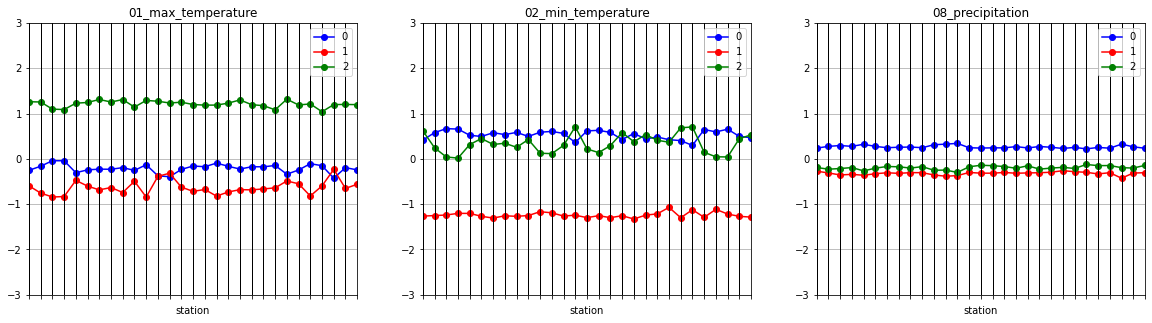

In [23]:
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))

names = [
    "01_max_temperature",
    "02_min_temperature",
    "08_precipitation"
]

fig = plt.figure(figsize=(20,5), facecolor='w')

for i,name in enumerate(names, 1):
    ax = fig.add_subplot(1, 3, i)
    ax.set_ylim([-3, +3])
    parallel_subplot(P, name[:2], fig=fig)
    ax.set_title(name)
    ax.set_xticklabels('')
    ax.set_xlabel('station')

plt.show()

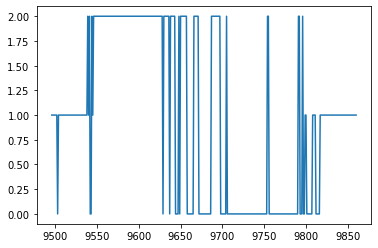

In [107]:
new = data.copy()
new['label'] = pd.Series(model.predict(X))
new[new.year==2019]['label'].plot()

In [108]:
def get_season():
    label = {}
    label['summer'] = P[get_features(P, '01')].mean(axis=1).idxmax()
    label['winter'] = P[get_features(P, '02')].mean(axis=1).idxmin()
    label['rainy']  = P[get_features(P, '08')].mean(axis=1).idxmax()
    return label

S = get_season()
S

{'rainy': 0, 'summer': 2, 'winter': 1}

In [109]:
S_inv = {val: key for key,val in S.items()}
new['label'] = new['label'].apply(lambda x: S_inv[x])
new.head()

,year,month,day,01BhumibolDam,01ChiangMai,01ChiangRai,01ChiangRaiAgromet,01DoiMuserAgromet,01KamphaengPhet,01Lampang,01LampangAgromet,01Lamphun,01LomSak,01MaeHongSon,01MaeSariang,01MaeSot,01NakhonSawan,01Nan,01NanAgromet,01Phayao,01Phitsanulok,01Phrae,01PichitAgromet,01SiSamrongAgromet,01Sukhothai,01Tak,01TakFaAgromet,01ThaWangPha,01ThungChang,01Umphang,01Uttaradit,01WichianBuri,02BhumibolDam,02ChiangMai,02ChiangRai,02ChiangRaiAgromet,02DoiMuserAgromet,02KamphaengPhet,02Lampang,02LampangAgromet,...,07PichitAgromet,07SiSamrongAgromet,07Sukhothai,07Tak,07TakFaAgromet,07ThaWangPha,07ThungChang,07Umphang,07Uttaradit,07WichianBuri,08BhumibolDam,08ChiangMai,08ChiangRai,08ChiangRaiAgromet,08DoiMuserAgromet,08KamphaengPhet,08Lampang,08LampangAgromet,08Lamphun,08LomSak,08MaeHongSon,08MaeSariang,08MaeSot,08NakhonSawan,08Nan,08NanAgromet,08Phayao,08Phitsanulok,08Phrae,08PichitAgromet,08SiSamrongAgromet,08Sukhothai,08Tak,08TakFaAgromet,08ThaWangPha,08ThungChang,08Umphang,08Uttaradit,08WichianBuri,label
0,1993,1,1,30.3,27.8,27.5,26.6,24.7,32.4,30.4,29.5,29.0,33.2,27.3,28.6,30.7,33.2,30.2,29.2,26.5,32.0,30.7,32.4,31.3,33.5,31.0,33.6,29.2,31.8,30.6,31.9,33.5,18.0,14.5,11.5,12.0,12.1,18.9,15.3,14.7,...,3.5,4.2,4.3,1.7,5.5,2.5,3.4,3.1,3.1,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,winter
1,1993,1,2,30.5,28.7,26.7,27.1,26.2,32.4,30.4,29.6,30.2,33.0,27.2,29.1,30.6,33.0,29.8,29.7,27.3,32.5,30.4,32.2,31.3,33.5,32.0,33.8,29.2,31.8,30.5,31.9,33.8,18.9,15.8,13.1,13.5,12.8,20.0,15.3,15.3,...,3.8,3.3,4.3,2.1,4.8,2.4,3.4,3.5,2.8,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,winter
2,1993,1,3,31.7,28.6,27.6,27.6,25.0,33.0,31.3,31.0,29.9,33.0,28.2,30.1,30.2,33.5,30.2,29.8,29.7,32.1,31.0,31.9,31.5,33.5,31.5,33.9,29.5,31.8,30.2,32.0,34.0,18.9,13.7,14.4,11.9,11.8,18.9,16.5,15.5,...,4.0,4.2,4.3,4.2,4.6,2.1,3.4,3.9,3.6,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,winter
3,1993,1,4,31.3,29.1,28.0,27.6,25.4,32.8,30.6,30.2,29.5,32.6,27.5,28.9,30.1,33.9,30.5,29.2,28.9,32.2,31.0,32.1,31.3,33.5,31.6,33.5,29.6,31.8,30.2,31.9,33.7,18.2,13.3,11.8,11.8,11.3,18.8,15.3,14.9,...,3.1,3.0,4.3,2.6,5.0,2.7,3.4,3.0,3.9,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,winter
4,1993,1,5,30.7,28.2,27.5,27.3,25.3,33.3,30.2,29.1,28.8,33.4,27.6,29.2,30.1,33.8,29.3,29.8,27.0,32.3,30.0,31.4,31.1,33.5,31.9,33.9,29.2,31.8,30.4,31.9,33.9,18.5,13.0,12.1,12.0,10.9,18.7,14.4,13.7,...,3.8,3.6,4.3,1.3,4.2,2.5,3.4,3.6,3.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,winter


In [112]:
new.to_csv("Add_season_label.csv")

In [110]:
YEARS = data.year.unique()
S_summer, S_rainy = [], []
for year in YEARS:
    df_year = new[new.year==year].reset_index(drop=True)
    query = df_year[df_year.label=='summer']
    S_summer.append(query.index[len(query)//2] / len(df_year))
    query = df_year[df_year.label=='rainy']
    S_rainy.append(query.index[len(query)//2] / len(df_year))

S_center = pd.DataFrame({'summer': S_summer, 'rainy': S_rainy}, index=YEARS)

In [111]:
S_center.head()

,summer,rainy
1993,0.317808,0.635616
1994,0.216438,0.578082
1995,0.265753,0.619178
1996,0.245902,0.595628
1997,0.309589,0.646575


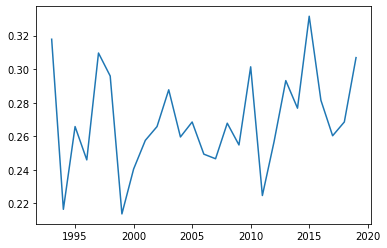

In [85]:
S_center.summer.plot()

In [87]:
S_center.to_csv("Center_of_season.csv")